<a href="https://colab.research.google.com/github/Pezzan/AI_workshop/blob/main/01-LLM_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop: Calling an LLM deployed in Azure AI Foundry using `AzureOpenAI` (Python, Colab)

## What you will learn
By the end of this workshop, you will be able to:
1. Understand what a *deployment* is in Azure AI Foundry.
2. Configure a Colab notebook safely (no secrets hard-coded).
3. Call your deployed LLM using the OpenAI Python SDK `AzureOpenAI` client.
4. Build a simple "conversation memory" mechanism by keeping and resending message history.

---

## Concept: Foundry deployments and endpoints

In Azure AI Foundry, you deploy a model as a **deployment**:
- A deployment is an Azure resource with a **deployment name**, model/version, and configuration.
- When you call the API, you route to the right deployment by using its **deployment name**.

Foundry can expose multiple endpoint styles. For this workshop we use the **Azure OpenAI inference endpoint** (the one that looks like `https://<resource>.openai.azure.com/`), because the `AzureOpenAI` client is built to talk to Azure OpenAI–style endpoints.

> Key rule for Azure OpenAI calls: the `model=` parameter is your **deployment name**.  
> If you pass the raw model name (e.g., "gpt-4o"), you will typically get an error unless your deployment name happens to match it.


In [ ]:
%pip -q install --upgrade openai azure-identity azure-identity-broker

## Setup: environment variables (safe in workshops)

We will NOT hard-code keys in the notebook.

You need three values from Azure AI Foundry / Azure OpenAI:

1. **AZURE_OPENAI_ENDPOINT**  
   Looks like: `https://YOUR_RESOURCE_NAME.openai.azure.com/`

3. **AZURE_OPENAI_DEPLOYMENT**  
   The **deployment name** you created in Foundry (this is what you pass as `model=` in the code).  
   Azure requires deployment names even when the parameter is called `model`. :contentReference[oaicite:1]{index=1}

4. **AZURE_OPENAI_API_VERSION** (classic API style)  
   In many Azure OpenAI examples with `AzureOpenAI`, you specify an `api_version` string (for example `2024-02-01`).  
   Your organization might standardize on a specific version; if so, use that.

In [ ]:
import os
from getpass import getpass
from azure.identity import DefaultAzureCredential

if not os.getenv("AZURE_CLIENT_SECRET"):
    os.environ["AZURE_CLIENT_SECRET"] = getpass("AZURE_CLIENT_SECRET: ")

os.environ["AZURE_TENANT_ID"] = "0f9e35db-544f-4f60-bdcc-5ea416e6dc70"
os.environ["AZURE_CLIENT_ID"] = "c473f6c5-2b24-44e5-b44f-b8897e21cbe5"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://unepazcdoopenaiprod01.openai.azure.com/"
os.environ["AZURE_OPENAI_DEPLOYMENT"] = "gpt-4o-mini"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-12-01-preview"

credential = DefaultAzureCredential()

print("Configured:")
print("  AZURE_OPENAI_ENDPOINT    =", os.environ["AZURE_OPENAI_ENDPOINT"])
print("  AZURE_OPENAI_DEPLOYMENT  =", os.environ["AZURE_OPENAI_DEPLOYMENT"])
print("  AZURE_OPENAI_API_VERSION =", os.environ["AZURE_OPENAI_API_VERSION"])


## Create a client

The OpenAI Python SDK provides `AzureOpenAI` for Azure OpenAI–style endpoints.

We'll pass:
- `azure_endpoint`: your endpoint base URL
- `api_key`: your Azure OpenAI key
- `api_version`: an Azure API version string (classic style)

Reminder:
- `model=...` must be your **deployment name** in Azure.


In [ ]:
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_ad_token=credential.get_token("https://cognitiveservices.azure.com/.default").token,
)

deployment_name = os.environ["AZURE_OPENAI_DEPLOYMENT"]

response = client.chat.completions.create(
    model=deployment_name,  # IMPORTANT: model = deployment name in Azure
    messages=[
        {"role": "system", "content": "You are a helpful assistant for a technical workshop."},
        {"role": "user", "content": "In 3 bullet points, explain what a model deployment is in Azure AI Foundry."},
    ],
    temperature=0.9,
    max_tokens=200,
)

print(response.choices[0].message.content)


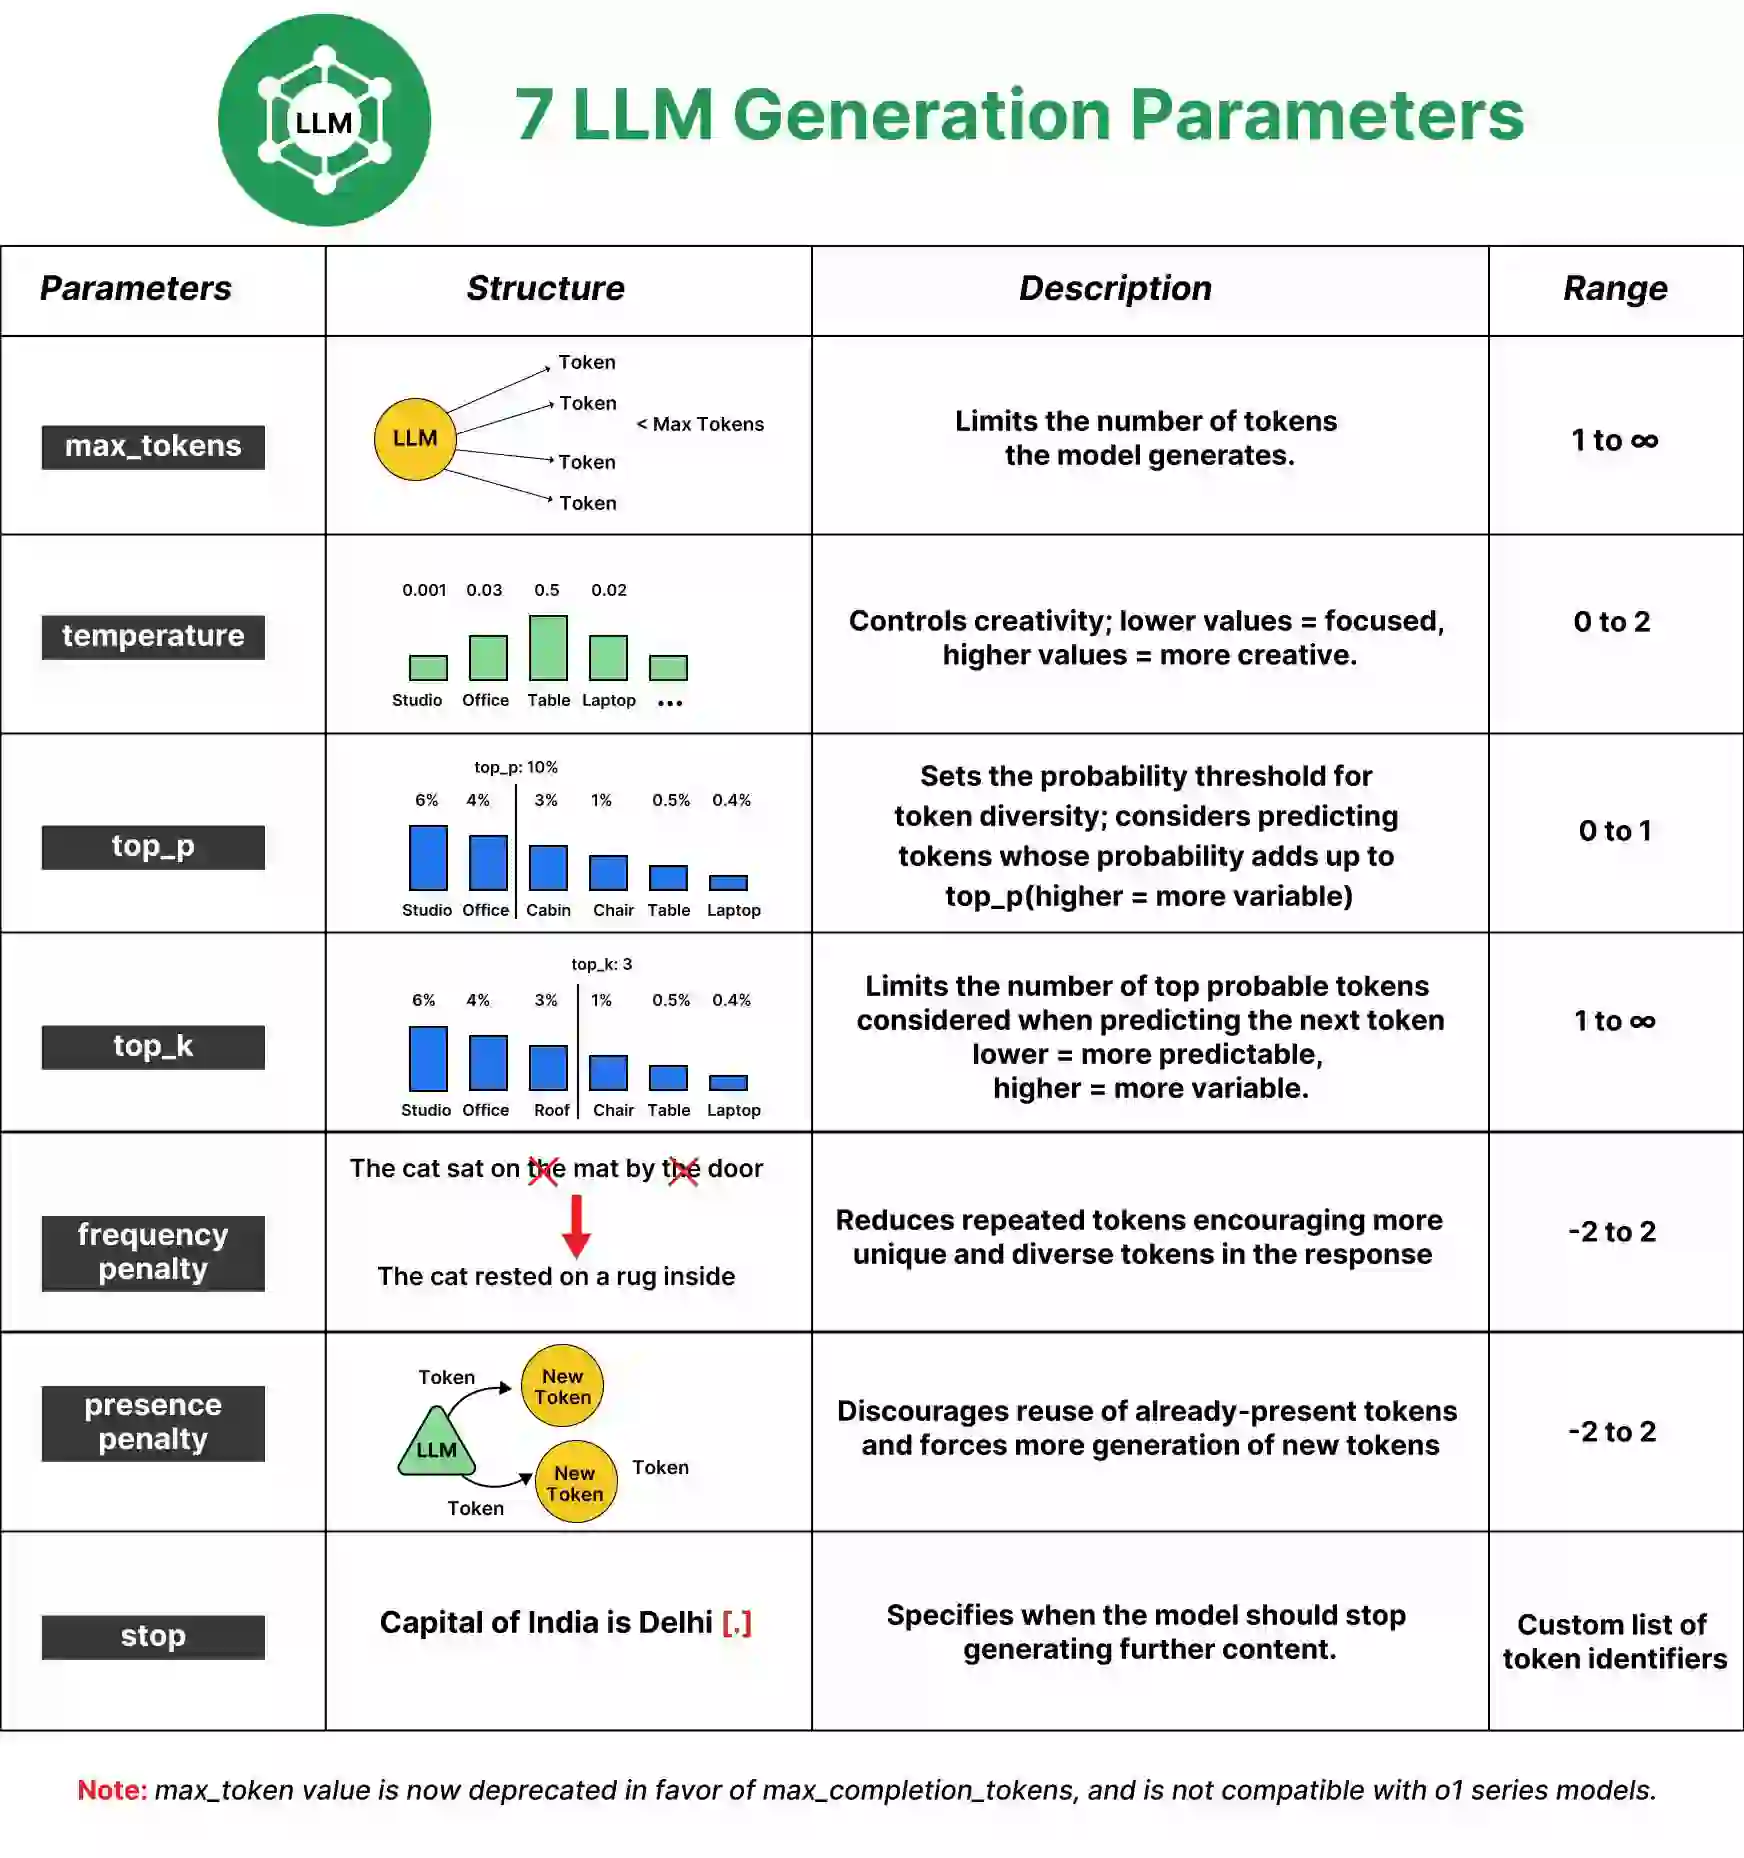

## A reusable helper

When teaching, it helps to show a clean function:

- Inputs:
  - `system_prompt` (controls assistant behavior)
  - `user_prompt` (the user's request)
- Output:
  - assistant text

This keeps the "SDK ceremony" separate from the teaching content.


In [ ]:
def ask_llm(user_prompt: str, system_prompt: str = "You are a helpful assistant.") -> str:
    resp = client.chat.completions.create(
        model=deployment_name,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.2,
        max_tokens=300,
    )
    return resp.choices[0].message.content

print(ask_llm("Write a 2-sentence explanation of what an API endpoint is."))


## Key idea: the model is stateless

A common beginner misconception is: “the model remembers what I said earlier”.

In reality, the API is **stateless**:
- The model does not keep your history between calls.
- If you want it to “remember”, you must send the relevant history again in the next request.

That’s why multi-turn chat is implemented by maintaining a `messages` list and resending it each time.

This is exactly how official guidance describes building a conversation loop: you keep a running transcript and send it with each new question, otherwise the model “loses context.”


In [ ]:
print(ask_llm("My name is Peppe. Remember it."))
print(ask_llm("What is my name?"))  # likely to fail because we didn't include prior context

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant. Keep answers short."}
]

def chat_with_memory(user_text: str) -> str:
    messages.append({"role": "user", "content": user_text})
    resp = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        temperature=0.2,
        max_tokens=200,
    )
    assistant_text = resp.choices[0].message.content
    messages.append({"role": "assistant", "content": assistant_text})
    return assistant_text

print(chat_with_memory("My name is Peppe. Remember it."))
print(chat_with_memory("What is my name?"))  # should succeed much more reliably